<a href="https://colab.research.google.com/github/sthagrowl/Offensive-Hate-Speech-Detection/blob/main/offensive_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Offensive/Hate Speech Detector


In [ ]:
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from tqdm import tqdm

In [ ]:

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

## Import the dataset

In [ ]:
data = pd.read_csv('dataset.csv', index_col=0)

In [ ]:
data.head()

,comment,hate_speech
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.shape

(159571, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   comment      159571 non-null  object
 1   hate_speech  159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [ ]:
#check the percentage of nan values 
data.isna().sum() / len(data) * 100

comment        0.0
hate_speech    0.0
dtype: float64

### Visualisation and Distrubution of the speech


<AxesSubplot:xlabel='hate_speech', ylabel='count'>

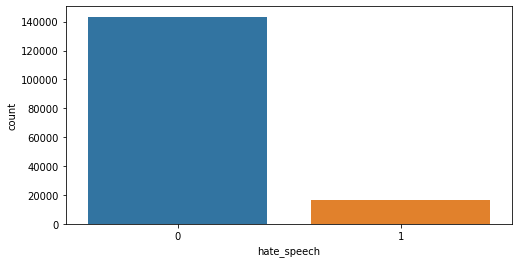

In [ ]:
fig, ax = plt.subplots(figsize = (8,4))
sns.countplot(x = data["hate_speech"])

In [ ]:
print(f'class 0 (non hate speech): {np.sum(data["hate_speech"] == 0) / len(data) *100:.2f}%')
print(f'class 1 (hate speech): {np.sum(data["hate_speech"] == 1) / len(data) *100:.2f}%')

class 0 (non hate speech): 89.83%
class 1 (hate speech): 10.17%


### Undersampling the data 

In [ ]:
hate_data = data.loc[data.hate_speech == 1]
non_hate_data = data.loc[data.hate_speech == 0]

In [ ]:
balanced_non_hate_data = data.loc[np.random.choice(non_hate_data.index, len(hate_data))]

In [ ]:
df = pd.concat([balanced_non_hate_data,hate_data])

<AxesSubplot:xlabel='hate_speech', ylabel='count'>

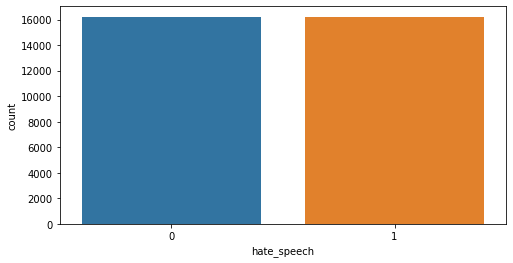

In [ ]:
fig, ax = plt.subplots(figsize = (8,4))
sns.countplot(x = df["hate_speech"])

In [ ]:
print(f'class 0 (non hate speech): {np.sum(df["hate_speech"] == 0) / len(df) *100:.2f}%')
print(f'class 1 (hate speech): {np.sum(df["hate_speech"] == 1) / len(df) *100:.2f}%')

class 0 (non hate speech): 50.00%
class 1 (hate speech): 50.00%


### Data preparation: train-val-test split

In [ ]:
def get_splits(x, y, splits):
    """
    The idea is to use an index list as reference:
    To shuffle it randomly:
    We need 'splits' to contain 2 values. 
  
    """
    # Create an index list and shuffle it - use the function random.shuffle
    data_len = len(x)
    index_list = np.arange(data_len)
    np.random.shuffle(index_list)
    # Find the two indexes we'll use to cut the lists from the splits
    train_cut_index = int(data_len*splits[0])
    valid_cut_index = int(data_len*(splits[0]+splits[1]))
    # Do the cutting (careful: you can't use a list as index for a list - this only works with tensors)
    # (you need to use list comprehensions - or go through numpy)
    train_x, train_y = np.take(x,index_list[:train_cut_index]),np.take(y,index_list[:train_cut_index])
    valid_x, valid_y = np.take(x,index_list[train_cut_index:valid_cut_index]),np.take(y,index_list[train_cut_index:valid_cut_index])
    test_x, test_y = np.take(x,index_list[valid_cut_index:]),np.take(y,index_list[valid_cut_index:])
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
# Choose the training, validation, testing splits
splits = (0.8, 0.1)
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = get_splits(df.comment, df.hate_speech, splits)

### Data Preprocessing

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def clean_and_tokenize(text):
    """  
    Process text function.
    Input: text
    Output: text_clean: a list of words containing the processed text 
    
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove hyperlinks    
    text = re.sub(r'https?://[^\s\n\r]+', '', text)
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    # remove numbers, points, 
    text = re.sub(r'[0-9]+', '',text)
    text = re.sub(r'\.', '', text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)    
    text = text.lower()
    # tokenize text
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    text_tokens = tokenizer.tokenize(text)
    text_clean = []
    
    for word in text_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            text_clean.append(stem_word)

    return text_clean

In [ ]:
clean_and_tokenize("I love machine learning 0 */nchsd<p> :)")

['love', 'machin', 'learn', 'nchsd', ':)']

In [ ]:
text_len = [len(clean_and_tokenize(s)) for s in df.comment]
text_len = [l for l in text_len if l <500]

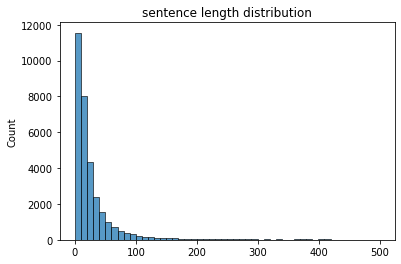

In [ ]:
sns.histplot(data=text_len,bins=50)
plt.title("sentence length distribution")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
from torchtext.vocab import vocab

from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence

from collections import Counter

#### Creating the Vocabulary


In [ ]:
def build_vocab(df, tokenizer,min_freq = 1):
    assert min_freq > 0
    counter = Counter(['<unk>', '<pad>']*min_freq)
    for s in df:
        counter.update(tokenizer(s))
    v =  vocab(counter,min_freq=min_freq)
    unk_token = '<unk>'
    v.set_default_index(v[unk_token])
    return v

In [ ]:
en_vocab = build_vocab(df.comment,clean_and_tokenize,min_freq=5)

In [ ]:
print(len(en_vocab))

10863


In [ ]:
PAD_IDX = en_vocab['<pad>']

#### Pytorch dataset

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 100,min_freq = 5):
        # Text data
        self.data = data
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.vocab = vocab
        else:
            # If no vocabulary imported, build it
            self.vocab = build_vocab(self.data, clean_and_tokenize,min_freq)

        # Tokenize the data
        # Transform words into lists of indexes
        # Transform this list of of indexes into Pytorch Tensor
        tensor_data = [ torch.tensor([vocab[w] for w in clean_and_tokenize(sentence)][:max_length]) for sentence in self.data ]
        self.tensor_data = pad_sequence(tensor_data, batch_first=True, padding_value = PAD_IDX)
        
        
        # Transform the categories into a FloatTensor
        self.tensor_y  = torch.FloatTensor(np.array(categories))
        
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.vocab

In [ ]:
training_dataset = TextClassificationDataset(train_x, train_y,en_vocab)
valid_dataset = TextClassificationDataset(valid_x, valid_y, en_vocab)
test_dataset = TextClassificationDataset(test_x, test_y,en_vocab)

In [ ]:
BATCH_SIZE = 128
## Dataloaders
training_dataloader = DataLoader(training_dataset, batch_size = BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

## Models

### Model 1 : Simple averaging model

In [ ]:
class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size,embedding_dim=embedding_dim,padding_idx= PAD_IDX)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.fc1 = nn.Linear(embedding_dim,1)
        
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs)
        x = torch.mean(x,dim=1)
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        x = self.fc1(x)
        o = torch.squeeze(x,dim=1)
        return o

### Model 2: Pretrained Averaging Model with Glove embeddings

In [ ]:
!pip install gensim

In [ ]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [ ]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    
    embeddings_d = glove_model.vectors.shape[1]
    embeddings_shape = (len(input_voc),embeddings_d)
    
    embeddings = np.random.normal(loc=0.0,scale=0.001,size=embeddings_shape)
    embeddings[input_voc["<pad>"],:] = np.zeros((embeddings_d,))
    embeddings[input_voc["<unk>"],:] = np.zeros((embeddings_d,))
    
    print(embeddings.shape)
    
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, en_vocab.get_stoi())

(10863, 300)


In [ ]:
class PretrainedAveragingModel(nn.Module):
    def __init__(self,fine_tuning=False):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(GloveEmbeddings))
        self.embeddings.requires_grad = fine_tuning
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(GloveEmbeddings.shape[1],1)
        
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs)
        x = torch.mean(x,dim=1)
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        x = self.linear(x)
        o = torch.squeeze(x,dim=1)
        return o

### Model 3: LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, embeddings=None, fine_tuning=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,batch_first=True)

        if embeddings is None:
            self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(GloveEmbeddings))
        else:
            self.embeddings = embeddings

        self.embeddings.requires_grad = fine_tuning
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(hidden_dim,1)

    def forward(self, inputs):
        x = self.embeddings(inputs)
        lstm_out, (ht, ct) = self.lstm(x)
        x = torch.squeeze(ht[-1],dim=0)
        x = self.linear(x)
        out = torch.squeeze(x,dim=1)
        return out

## Train

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda


In [ ]:
def train_epoch(model, opt, criterion, dataloader,disable_bar = False):
    model.train()
    losses = []
    accuracies = []
    with tqdm(total=len(dataloader), disable=disable_bar) as pbar:
        for i, (x, y) in enumerate(dataloader):
            opt.zero_grad()
            # Forward
            x, y = x.to(device), y.to(device)
            pred = model(x)
            # Compute the loss 
            loss = criterion(pred,y)
            # Compute gradients with the criterion
            loss.backward()
            # Update weights with the optimizer
            opt.step() 
            losses.append(loss.item())
            
            # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid
            num_corrects = ((pred>0) == y).sum() 
            acc = 100.0 * num_corrects/len(y)
            accuracies.append(acc.item())
            
            training_loss = np.mean(losses)
            training_accurcy = np.mean(accuracies)
            
            pbar.set_description(f'training loss: {training_loss:.4f}, training acc: {training_accurcy:.4f}')
            pbar.update(1)
            
    return losses

In [ ]:
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred,y)
            num_corrects = ((pred>0) == y).sum() 
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
# A function which will help to execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, use_early_stopping = True):
    train_losses = []
    if use_early_stopping:
        early_stopping = EarlyStopping(patience=5,min_delta=0.01)
        
    print("Beginning training...")
        
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
            
        train_losses += train_epoch(model, opt, criterion, training_dataloader,disable_bar=False)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        
        print(f'Validation loss: {valid_loss:.4f}, Validation acc: {valid_acc:.4f}')
            
        if use_early_stopping:
            early_stopping(valid_loss)
            if early_stopping.early_stop:
                break  
            
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print(f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')
        
    return train_losses

### Model selection

#### Model 1

In [ ]:
model1 = AveragingModel(300, len(en_vocab))
model1 = model1.to(device)
# Create an optimizer
opt = optim.Adam(model1.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
# pos_weight = torch.tensor([9]).to(device)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses = experiment(model1, opt, criterion,num_epochs=10)

Beginning training...
Epoch 1:


training loss: 0.5595, training acc: 76.4411: 100%|██████████| 203/203 [00:04<00:00, 44.15it/s] 


Validation loss: 0.4462, Validation acc: 83.7385
Epoch 2:


training loss: 0.3572, training acc: 87.7093: 100%|██████████| 203/203 [00:01<00:00, 104.25it/s]


Validation loss: 0.3676, Validation acc: 87.3077
Epoch 3:


training loss: 0.2697, training acc: 91.2914: 100%|██████████| 203/203 [00:02<00:00, 100.55it/s]


Validation loss: 0.3426, Validation acc: 88.8077
Epoch 4:


training loss: 0.2180, training acc: 93.0271: 100%|██████████| 203/203 [00:02<00:00, 87.51it/s] 


Validation loss: 0.3380, Validation acc: 89.4538
INFO: Early stopping counter 1 of 5
Epoch 5:


training loss: 0.1841, training acc: 94.1198: 100%|██████████| 203/203 [00:02<00:00, 94.29it/s]


Validation loss: 0.3495, Validation acc: 89.7077
INFO: Early stopping counter 2 of 5
Epoch 6:


training loss: 0.1599, training acc: 94.8223: 100%|██████████| 203/203 [00:02<00:00, 97.49it/s] 


Validation loss: 0.3632, Validation acc: 89.8615
INFO: Early stopping counter 3 of 5
Epoch 7:


training loss: 0.1422, training acc: 95.3782: 100%|██████████| 203/203 [00:01<00:00, 102.01it/s]


Validation loss: 0.3831, Validation acc: 89.6692
INFO: Early stopping counter 4 of 5
Epoch 8:


training loss: 0.1283, training acc: 95.8323: 100%|██████████| 203/203 [00:01<00:00, 105.18it/s]


Validation loss: 0.4089, Validation acc: 89.3923
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Test loss: 0.3630, Test acc: 89.0462


#### Model2 

In [ ]:
model2 = PretrainedAveragingModel(fine_tuning=False)
model2 = model2.to(device)
# Create an optimizer
opt = optim.Adam(model2.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses = experiment(model2, opt, criterion,num_epochs=5)

Beginning training...
Epoch 1:


training loss: 0.6307, training acc: 73.7090: 100%|██████████| 203/203 [00:00<00:00, 219.25it/s]


Validation loss: 0.5925, Validation acc: 76.3462
Epoch 2:


training loss: 0.5620, training acc: 77.4636: 100%|██████████| 203/203 [00:00<00:00, 228.32it/s]


Validation loss: 0.5476, Validation acc: 78.9692
Epoch 3:


training loss: 0.5236, training acc: 79.9889: 100%|██████████| 203/203 [00:00<00:00, 218.51it/s]


Validation loss: 0.5193, Validation acc: 80.7846
Epoch 4:


training loss: 0.4979, training acc: 81.6292: 100%|██████████| 203/203 [00:00<00:00, 219.52it/s]


Validation loss: 0.4996, Validation acc: 81.5538
Epoch 5:


training loss: 0.4792, training acc: 82.3844: 100%|██████████| 203/203 [00:00<00:00, 209.74it/s]


Validation loss: 0.4855, Validation acc: 82.0769
Test loss: 0.4886, Test acc: 81.2538


In [ ]:
model2.embeddings.requires_grad = True
train_losses = experiment(model2, opt, criterion,num_epochs=5)

Beginning training...
Epoch 1:


training loss: 0.4650, training acc: 82.9738: 100%|██████████| 203/203 [00:01<00:00, 172.94it/s]


Validation loss: 0.4741, Validation acc: 82.3538
Epoch 2:


training loss: 0.4535, training acc: 83.2204: 100%|██████████| 203/203 [00:01<00:00, 159.22it/s]


Validation loss: 0.4661, Validation acc: 82.3231
INFO: Early stopping counter 1 of 5
Epoch 3:


training loss: 0.4445, training acc: 83.5982: 100%|██████████| 203/203 [00:01<00:00, 152.34it/s]


Validation loss: 0.4580, Validation acc: 82.3846
Epoch 4:


training loss: 0.4367, training acc: 83.7462: 100%|██████████| 203/203 [00:01<00:00, 164.93it/s]


Validation loss: 0.4515, Validation acc: 82.6308
INFO: Early stopping counter 1 of 5
Epoch 5:


training loss: 0.4305, training acc: 83.9046: 100%|██████████| 203/203 [00:01<00:00, 168.44it/s]


Validation loss: 0.4473, Validation acc: 82.7231
Test loss: 0.4506, Test acc: 82.6385


#### Model3

In [ ]:
model3 = LSTMModel(300,64, embeddings=model1.embeddings, fine_tuning=False)
model3 = model3.to(device)
# Create an optimizer
opt = optim.Adam(model3.parameters(), lr=0.001, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses = experiment(model3, opt, criterion,num_epochs=10)

Beginning training...
Epoch 1:


training loss: 0.5661, training acc: 67.5333: 100%|██████████| 203/203 [00:04<00:00, 41.82it/s]


Validation loss: 0.4767, Validation acc: 81.8385
Epoch 2:


training loss: 0.4177, training acc: 85.2163: 100%|██████████| 203/203 [00:04<00:00, 46.39it/s]


Validation loss: 0.4875, Validation acc: 79.0923
INFO: Early stopping counter 1 of 5
Epoch 3:


training loss: 0.4054, training acc: 83.8984: 100%|██████████| 203/203 [00:04<00:00, 46.57it/s]


Validation loss: 0.4705, Validation acc: 80.5615
INFO: Early stopping counter 2 of 5
Epoch 4:


training loss: 0.3847, training acc: 85.4866: 100%|██████████| 203/203 [00:04<00:00, 46.66it/s]


Validation loss: 0.4688, Validation acc: 81.3615
INFO: Early stopping counter 3 of 5
Epoch 5:


training loss: 0.3800, training acc: 85.8975: 100%|██████████| 203/203 [00:04<00:00, 47.23it/s]


Validation loss: 0.4676, Validation acc: 81.3000
INFO: Early stopping counter 4 of 5
Epoch 6:


training loss: 0.3732, training acc: 86.5296: 100%|██████████| 203/203 [00:04<00:00, 47.98it/s]


Validation loss: 0.4670, Validation acc: 81.8846
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Test loss: 0.4699, Test acc: 81.9308


### Hyperparameter Tuning

In [ ]:
!pip install ray
!pip install -U tensorboardx

In [ ]:
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
def train_hsr(config,checkpoint_dir=None):
    model =  AveragingModel(config["d_embedding"], len(en_vocab))
    model = model.to(device)
    
    optimizer  = optim.Adam(model.parameters(), lr=config["lr"], betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()
    
    training_dataloader = DataLoader(training_dataset, batch_size = int(config["batch_size"]), shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = int(config["batch_size"]))
    
    early_stopping = EarlyStopping(patience=5,min_delta=0.01)
    for epoch in range(20):
        train_epoch(model, optimizer, criterion, training_dataloader,disable_bar=True)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)

        tune.report(loss=valid_loss, accuracy=valid_acc)
        
        early_stopping(valid_loss)
        if early_stopping.early_stop:
                break  
        
    print("Finished Training")
        

In [ ]:
def hyperparameter_search(config,num_samples=10, max_num_epochs=10):
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = JupyterNotebookReporter(
        overwrite= True,
        metric_columns=["loss", "accuracy", "training_iteration"])
    
    result = tune.run(
        train_hsr,
        resources_per_trial={"gpu": 1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))


#### model 1

In [ ]:
config = {
        "d_embedding" : tune.choice([64,128,256,300]),
        "lr": tune.choice([0.02,0.01,0.0025]),#tune.loguniform(1e-4, 1e-3),
        "batch_size": tune.choice([32,64,128])
    }

In [ ]:
hyperparameter_search(config,num_samples=20)

Trial name,status,loc,batch_size,d_embedding,lr,loss,accuracy,training_iteration
train_hsr_4103c_00000,TERMINATED,127.0.0.1:17676,32,128,0.01,0.473745,88.3578,6
train_hsr_4103c_00001,TERMINATED,127.0.0.1:23956,64,256,0.01,0.293922,89.4349,1
train_hsr_4103c_00002,TERMINATED,127.0.0.1:2288,64,128,0.0025,0.429869,84.2361,1
train_hsr_4103c_00003,TERMINATED,127.0.0.1:8212,64,300,0.01,0.475382,88.2224,6
train_hsr_4103c_00004,TERMINATED,127.0.0.1:14436,64,128,0.0025,0.422552,85.094,1
train_hsr_4103c_00005,TERMINATED,127.0.0.1:3744,64,64,0.01,0.314119,89.006,1
train_hsr_4103c_00006,TERMINATED,127.0.0.1:17592,128,256,0.0025,0.451825,83.5664,1
train_hsr_4103c_00007,TERMINATED,127.0.0.1:14864,128,64,0.0025,0.555954,78.1671,1
train_hsr_4103c_00008,TERMINATED,127.0.0.1:11544,64,300,0.0025,0.381619,86.3583,1
train_hsr_4103c_00009,TERMINATED,127.0.0.1:7204,32,300,0.02,0.30207,89.2157,2


2021-12-14 20:44:37,504	INFO tune.py:626 -- Total run time: 437.31 seconds (436.49 seconds for the tuning loop).


Best trial config: {'d_embedding': 256, 'lr': 0.01, 'batch_size': 64}
Best trial final validation loss: 0.2939215717362423
Best trial final validation accuracy: 89.43491288727405


### Best model

In [ ]:
BATCH_SIZE = 64
## Dataloaders
training_dataloader = DataLoader(training_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
model1 = AveragingModel(256, len(en_vocab))
model1 = model1.to(device)
# Create an optimizer
opt = optim.Adam(model1.parameters(), lr=0.01, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
# pos_weight = torch.tensor([9]).to(device)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
losses = experiment(model1, opt, criterion,num_epochs=20,use_early_stopping=True)

Beginning training...
Epoch 1:


training loss: 0.0955, training acc: 96.6302: 100%|██████████| 406/406 [00:04<00:00, 98.13it/s]


Validation loss: 0.5103, Validation acc: 87.8769
Epoch 2:


training loss: 0.0892, training acc: 96.8065: 100%|██████████| 406/406 [00:04<00:00, 96.60it/s]


Validation loss: 0.5636, Validation acc: 87.9385
INFO: Early stopping counter 1 of 5
Epoch 3:


training loss: 0.0811, training acc: 97.0312: 100%|██████████| 406/406 [00:04<00:00, 95.72it/s]


Validation loss: 0.5959, Validation acc: 87.5077
INFO: Early stopping counter 2 of 5
Epoch 4:


training loss: 0.0774, training acc: 97.2421: 100%|██████████| 406/406 [00:04<00:00, 87.54it/s]


Validation loss: 0.6431, Validation acc: 87.8154
INFO: Early stopping counter 3 of 5
Epoch 5:


training loss: 0.0724, training acc: 97.3738: 100%|██████████| 406/406 [00:04<00:00, 91.11it/s]


Validation loss: 0.6892, Validation acc: 87.7538
INFO: Early stopping counter 4 of 5
Epoch 6:


training loss: 0.0694, training acc: 97.5754: 100%|██████████| 406/406 [00:04<00:00, 92.19it/s]


Validation loss: 0.7322, Validation acc: 87.3538
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Test loss: 0.7870, Test acc: 88.2000


## Inspect model

In [ ]:
def hate_speech_recognition(text,model):
    text_dataset = TextClassificationDataset([text],[0],en_vocab)
    text_dataloader = DataLoader(text_dataset, batch_size = 1)
    x,y = next(iter(text_dataloader))
    
    model.eval()
    with torch.no_grad():
        pred = model(x)
        ## less than 0 -> non hate (class 0)
        ## else Hate -> (class 1)
        ## since there is no sigmoid acivation in the last layer 
        text_class = (pred>0)
    result = text_class[0].item()
    
    ## print results
    if result:
        print("hate speech detected")
    else:
        print("non hate speech")
    
    return result

In [ ]:
model1 = model1.to("cpu")

In [ ]:
hate_speech_recognition("I hate you",model=model1)

hate speech detected


True

In [ ]:
def inspect_model(model, evalloader):
    model.eval()
    false_positive = []
    false_negative = []
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            text_class = (pred>0)
            
            if text_class != y:
                result = text_class[0].item()
                if result:
                    false_positive.append(i)
                else:
                    false_negative.append(i)
    return false_positive,false_negative


inspect_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False)
false_positive,false_negative = inspect_model(model1,inspect_dataloader)

In [ ]:
print(len(false_positive))

179


### False Hate (false Positive)

In [ ]:
## false Positive
for i in false_positive[14:16]:
    text = test_x.iloc[i]
    pred_label = hate_speech_recognition(text,model=model1)
    true_label = test_y.iloc[i]
    print("PLAIN text:")
    print(text)
    print()
    print("TOKENIZED TEXT:")
    print(clean_and_tokenize(text))
    print()
    print("Predicted: ","Hate" if pred_label else "Non hate")
    print("True Label: ","Hate" if true_label==1 else "Non hate")

hate speech detected
PLAIN text:
Ombudsman

is there for for Wiki?

beckjord

TOKENIZED TEXT:
['ombudsman', 'wiki', 'beckjord']

Predicted:  Hate
True Label:  Non hate
hate speech detected
PLAIN text:
Thanks! ) 

Hi, just wanted to let you know that I think you're a total loser to be patrolling recent changes.  Go outside and do us all a favor.
Note: you ARE being reported for vandalism  stop it.

TOKENIZED TEXT:
['thank', 'want', 'let', 'know', 'think', 'total', 'loser', 'patrol', 'recent', 'chang', 'outsid', 'favor', 'note', 'report', 'vandal', 'stop']

Predicted:  Hate
True Label:  Non hate


### False Non Hate (false Negative)

In [ ]:
## false Negative
for i in false_negative[32:33]:
    text = test_x.iloc[i]
    pred_label = hate_speech_recognition(text,model=model1)
    true_label = test_y.iloc[i]
    print("PLAIN text:")
    print(text)
    print()
    print("TOKENIZED TEXT:")
    print(clean_and_tokenize(text))
    print()
    print("Predicted: ","Hate" if pred_label else "Non hate")
    print("True Label: ","Hate" if true_label==1 else "Non hate")

non hate speech
PLAIN text:
Definition of fat- Lauren Lozano!

TOKENIZED TEXT:
['definit', 'fat', 'lauren', 'lozano']

Predicted:  Non hate
True Label:  Hate
